In [40]:
import logging
import os.path

import numpy as np
from poap.controller import BasicWorkerThread, ThreadController

from pySOT.auxiliary_problems import candidate_uniform
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.experimental_design import LatinHypercube
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.strategy import SRBFStrategy
from pySOT.optimization_problems import Ackley
from pySOT.utils import unit_rescale
from pySOT.strategy import DYCORSStrategy
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import scipy.spatial as scpspatial
import scipy
from scipy.integrate import quad
import random

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [51]:
class Lm_ackley(Ackley):
    """Ackley function

    .. math::
        f(x_1,\\ldots,x_n) = -20\\exp\\left( -0.2 \\sqrt{\\frac{1}{n} \
        \\sum_{j=1}^n x_j^2} \\right) -\\exp \\left( \\frac{1}{n} \
        \\sum{j=1}^n \\cos(2 \\pi x_j) \\right) + 20 - e

    subject to

    .. math::
        -15 \\leq x_i \\leq 20

    Global optimum: :math:`f(0,0,...,0)=0`

    :ivar dim: Number of dimensions
    :ivar lb: Lower variable bounds
    :ivar ub: Upper variable bounds
    :ivar int_var: Integer variables
    :ivar cont_var: Continuous variables
    :ivar min: Global minimum value
    :ivar minimum: Global minimizer
    :ivar info: String with problem info
    """

    def __init__(self, dim=10,ep = 1):
        self.ep = ep
        self.dim = dim
        #self.c = self.eval(np.random.random(size = self.dim))
        self.c = 0
        self.H_ys = []
        self.beta = 1/ep
        self.min = 0
        self.minimum = np.zeros(dim)
        self.lb = -15 * np.ones(dim)
        self.ub = 20 * np.ones(dim)
        self.int_var = np.array([])
        self.cont_var = np.arange(0, dim)
        self.info = str(dim) + "-dimensional Ackley function \n" + "Global optimum: f(0,0,...,0) = 0"

        # linear f
    def eval1(self, x):
        """Evaluate the modified ackley function  at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        if H_y <= self.c:
            self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.log((H_y - self.c + self.ep)/self.ep)
        else:
            return (
                scipy.integrate.quad(lambda u: 1/(u - self.c + self.ep), a = self.min, b = H_y)[0]
            )
    
    # quadratic f
    def eval2(self, x):
        """Evaluate the modified ackley function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.sqrt(self.beta)*np.arctan(np.sqrt(self.beta)*(H_y - self.c))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**2 + self.ep), a = self.min, b = H_y)[0]
            )
    
    # square root f
    def eval3(self, x):
        """Evaluate the modified ackley function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        if H_y <= self.c:
            self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return (self.beta*(self.c - self.min) + 2*np.sqrt(H_y - self.c)
                    - 2*self.ep*np.log((np.sqrt(H_y - self.c) + self.ep)/self.ep))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**(1/2) + self.ep), a = self.min, b = H_y)[0]
            )


In [26]:
def ex_helper(times):
    max_evals = 300
    l2 = np.zeros((max_evals,times))
    for i in range(times):
        np.random.seed(i)
        random.seed(i)
        lm_ackley = Lm_ackley()
        rbf = RBFInterpolant(dim=lm_ackley.dim, lb=lm_ackley.lb, ub=lm_ackley.ub, kernel=CubicKernel(), tail=LinearTail(lm_ackley.dim))
        slhd = SymmetricLatinHypercube(dim=lm_ackley.dim, num_pts=2 * (lm_ackley.dim + 1))
        controller1 = SerialController(objective=lm_ackley.eval)
        controller1.strategy = SRBFStrategy(
            max_evals=max_evals, opt_prob=lm_ackley, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
            )

        # Run the optimization strategy
        result1 = controller1.run()
        l2[:,i] = np.array(
                [o.value for o in controller1.fevals if o.value is not None])
    return l2

In [27]:
l2 = ex_helper(30)

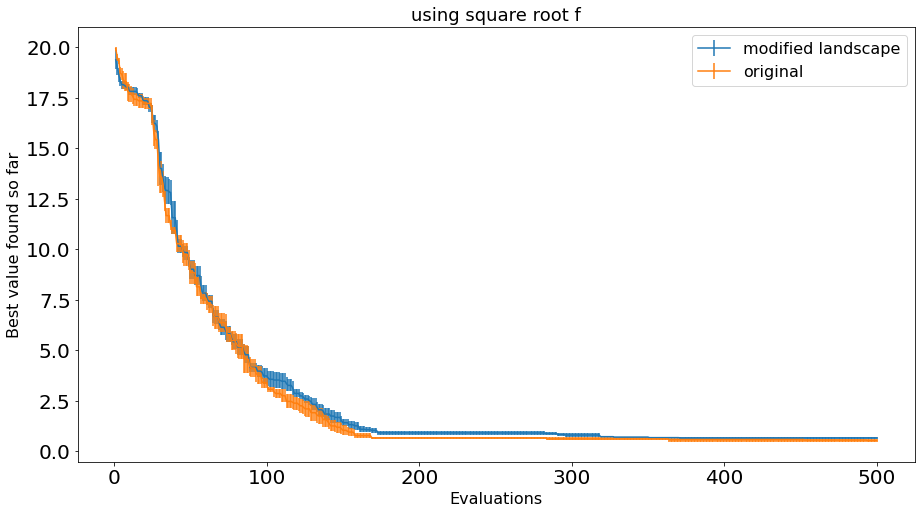

In [5]:
def plotter():
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    num_threads = 4
    max_evals = 500
    num_runs = 5
    lm_ackley = Lm_ackley(dim=10)
    rbf = RBFInterpolant(dim=lm_ackley.dim, lb=lm_ackley.lb, ub=lm_ackley.ub, kernel=CubicKernel(), tail=LinearTail(lm_ackley.dim))
    slhd = SymmetricLatinHypercube(dim=lm_ackley.dim, num_pts=2 * (lm_ackley.dim + 1))

    results_async1 = np.zeros((max_evals, num_runs))
    for i in range(num_runs):
        # can change landscape by changing eval1 to eval2 or eval3 based on preferance
        controller1 = SerialController(objective=lm_ackley.eval3)
        controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_ackley, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
        result = controller1.run()
        results_async1[:, i] = np.array(
            [H_y for H_y in lm_ackley.H_ys[i * max_evals:] if H_y is not None])
        
    results_async2 = np.zeros((max_evals, num_runs))
    for i in range(num_runs):
        controller2 = SerialController(objective=lm_ackley.eval)
        controller2.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_ackley, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
        result = controller2.run()
        results_async2[:, i] = np.array(
            [o.value for o in controller2.fevals if o.value is not None])

    plt.figure(figsize=(15, 8))
    for results in [results_async1, results_async2]:
        fvals = np.minimum.accumulate(results)
        plt.errorbar(np.arange(max_evals)+1, y=np.mean(fvals, axis=1), 
                     yerr=np.std(fvals, axis=1)/np.sqrt(float(num_runs)))

#     plt.plot(np.arange(0, fvals.shape[0]), np.minimum.accumulate(fvals), lw=2)
    plt.ylabel("Best value found so far", fontsize=16)
    plt.xlabel("Evaluations", fontsize=16)
    plt.legend(("modified landscape", "original"), fontsize=16)
    plt.title('using square root f',fontsize = 18)
    plt.show()



random.seed(0)
np.random.seed(0)
plotter()

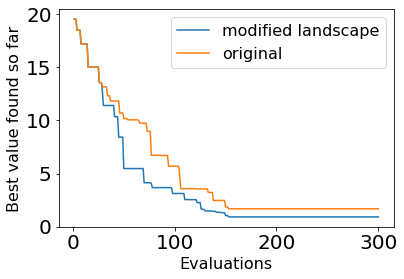

(0.9130335066932038, 1.6779803121709205)

In [59]:
%matplotlib inline
path = '/Users/venkatkrishnakarumanchi/Desktop/plots'

def example_simple(state,path,i,l2):
    np.random.seed(state)
    random.seed(state)
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    max_evals = 300
    
    lm_ackley = Lm_ackley(dim=10)
    rbf = RBFInterpolant(dim=lm_ackley.dim, lb=lm_ackley.lb, ub=lm_ackley.ub, kernel=CubicKernel(), tail=LinearTail(lm_ackley.dim))
    slhd = SymmetricLatinHypercube(dim=lm_ackley.dim, num_pts=2 * (lm_ackley.dim + 1))

    # Create a strategy and a controller
    # can change landscape by changing eval1 to eval2 or eval3 based on preferance
    controller = SerialController(objective=lm_ackley.eval2)
    controller.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_ackley, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )

    # Run the optimization strategy
    result = controller.run()
    l1 = lm_ackley.H_ys


    # Create a strategy and a controller
    
    controller1 = SerialController(objective=lm_ackley.eval)
    controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_ackley, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )


    fvals1 = np.minimum.accumulate(l1)
    fvals2 = np.minimum.accumulate(l2[:,i])
    for results in [fvals1,fvals2]:
        plt.errorbar(np.arange(start = 0, stop = 300)+1, y=results)

    plt.ylabel("Best value found so far", fontsize=16)
    plt.xlabel("Evaluations", fontsize=16)
    plt.legend(("modified landscape", "original"), fontsize=16)
    #plt.title('using quadratic f, best value using landscape modification is {0} and other is {1}'.
     #         format(lm_ackley.eval(result.params[0]),min(l2[:,i])),
      #        fontsize = 12)
    plt.savefig(path + '/graph_iter_{0}.jpg'.format(i), dpi = 100)
    plt.show()

    
    return lm_ackley.eval(result.params[0]),min(l2[:,i])
    


example_simple(3,path,3,l2)

In [53]:

def rmse(x,x1):
    return np.sqrt(np.mean((x - x1)**2))

def checker(times,path,l2):
    lm = 0
    lm_list = []
    no_lm = 0
    no_lm_list = []
    folder = path
    for i in range(times):
        res = example_simple(i,path,i,l2)
        lm_list.append(res[0])
        no_lm_list.append(res[1])
        if res[0] < res[1]:
            lm += 1
        else:
            no_lm += 1
    print('landscape modified was better {0} times and was worse {1} times'.format(lm,no_lm))
    print('mean of landscape modified is {}'.format(np.mean(lm_list)))
    print('mean of non landscape modified is {}'.format(np.mean(no_lm_list)))
    print('median of landscape modified is {}'.format(np.median(lm_list)))
    print('median of non landscape modified is {}'.format(np.median(no_lm_list)))
    print('standard_deviation of landscape modified is {}'.format(np.std(lm_list)))
    print('standard_deviation of non landscape modified is {}'.format(np.std(no_lm_list)))
    print('best result of landscape modified is {}'.format(np.min(lm_list)))
    print('best of non landscape modified is {}'.format(np.min(no_lm_list)))
    print('worst result of landscape modified is {}'.format(np.max(lm_list)))
    print('worst of non landscape modified is {}'.format(np.max(no_lm_list)))
    return lm_list,no_lm_list

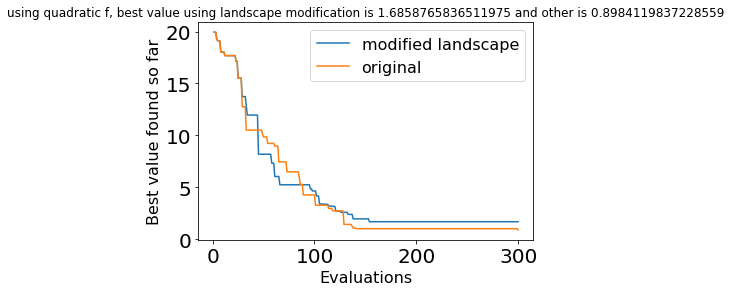

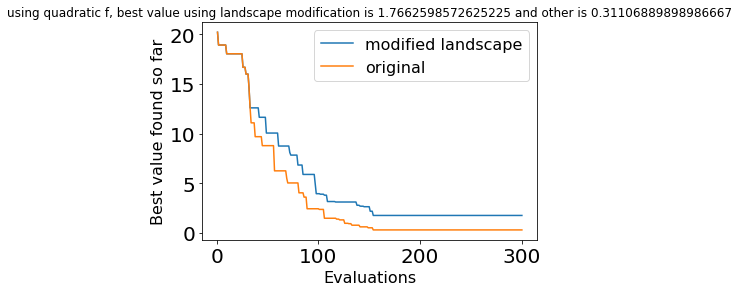

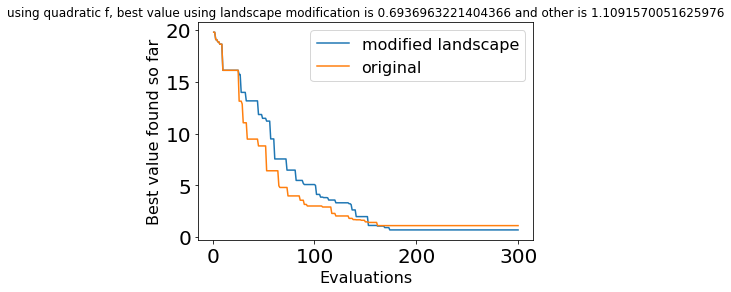

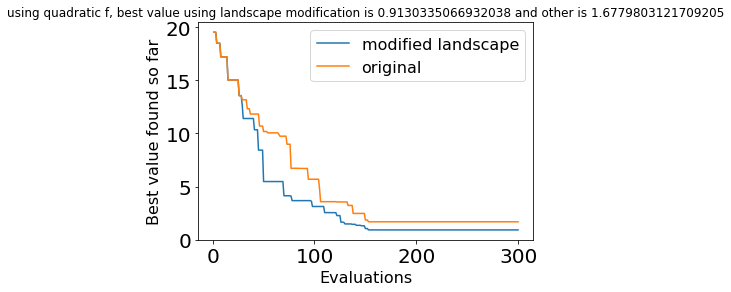

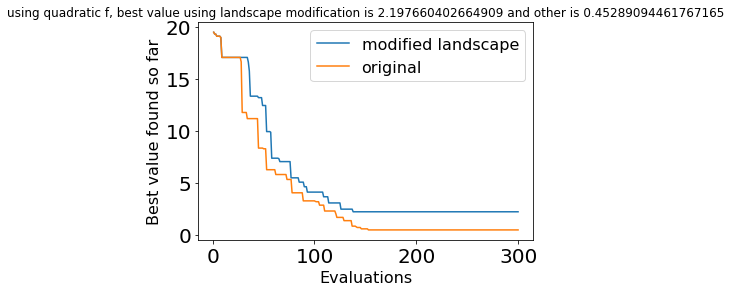

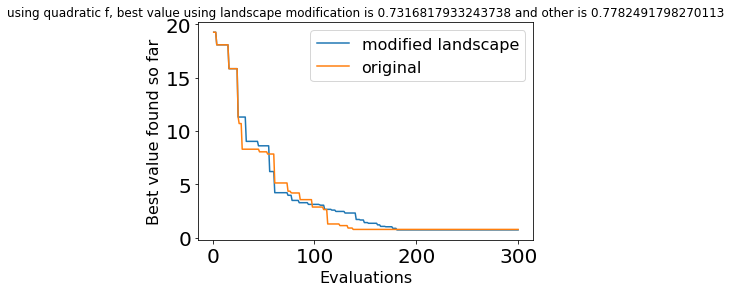

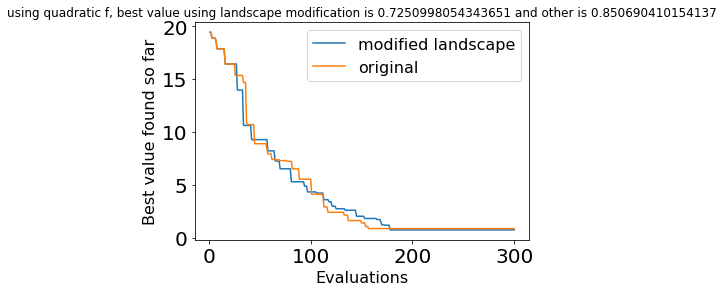

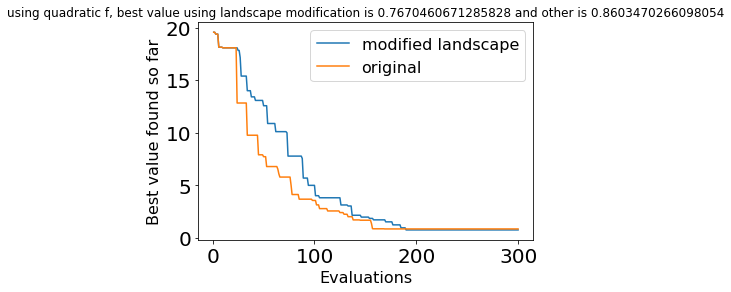

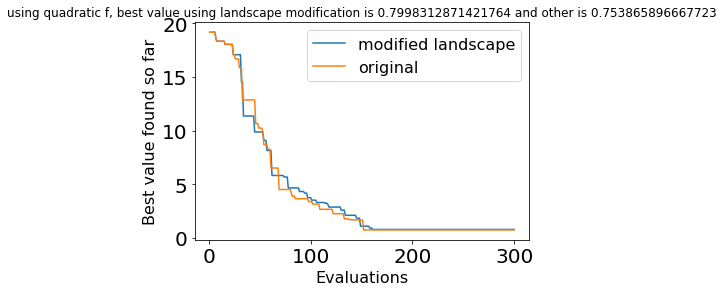

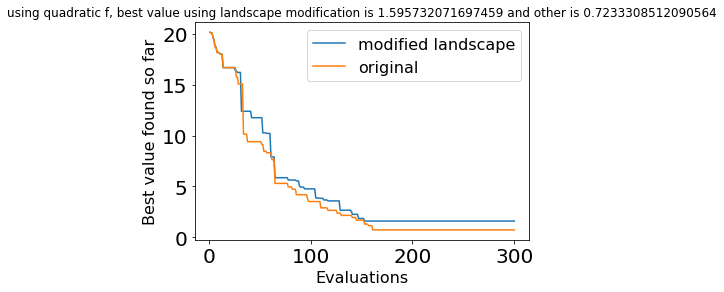

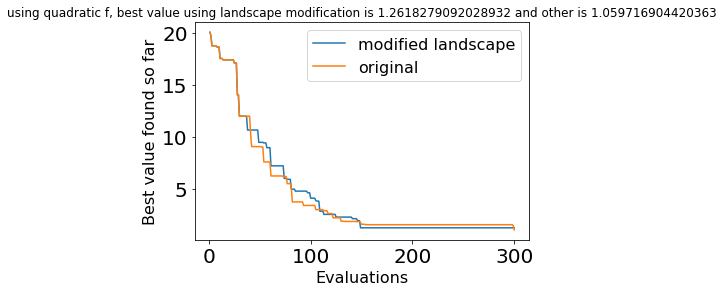

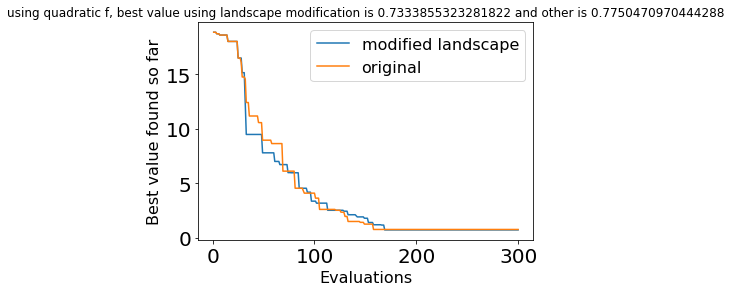

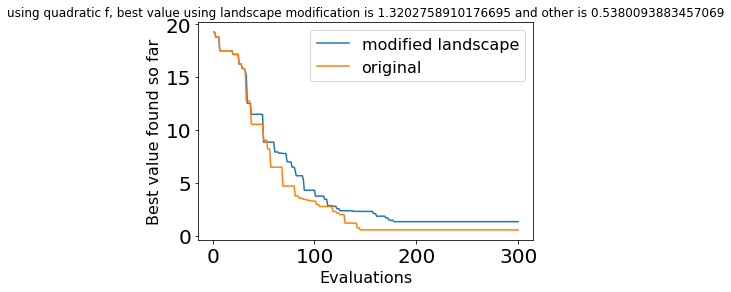

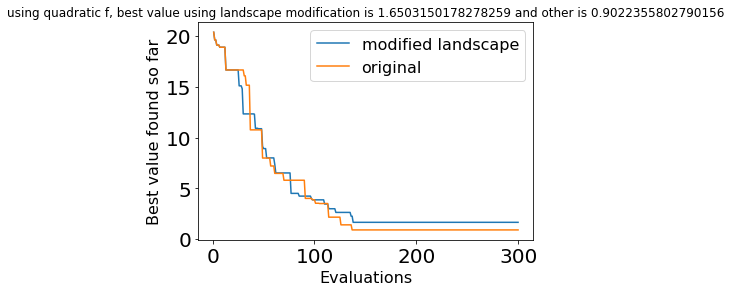

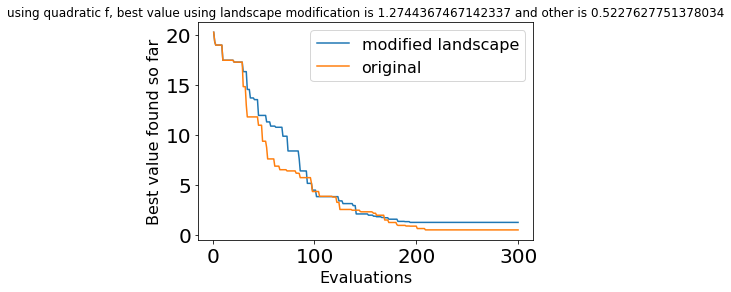

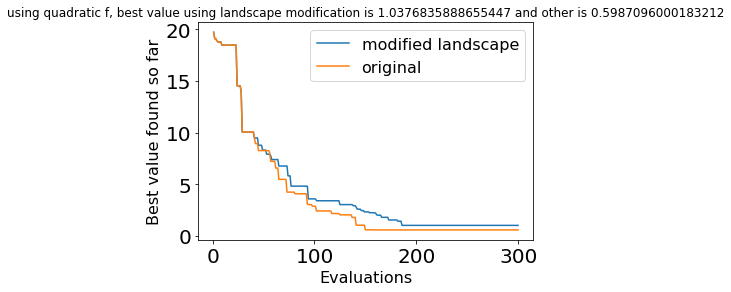

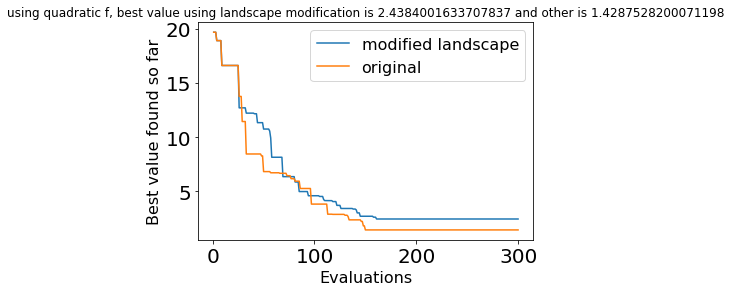

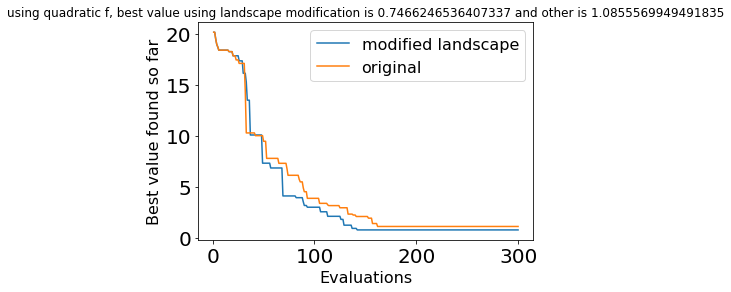

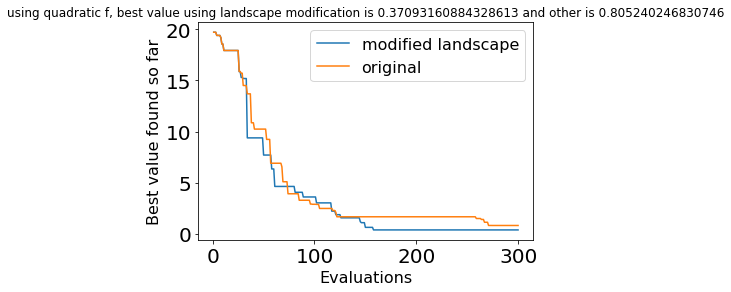

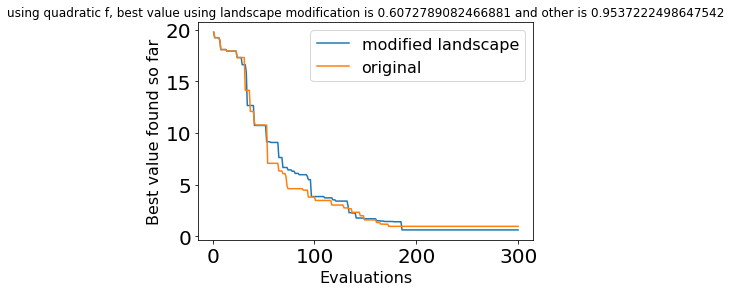

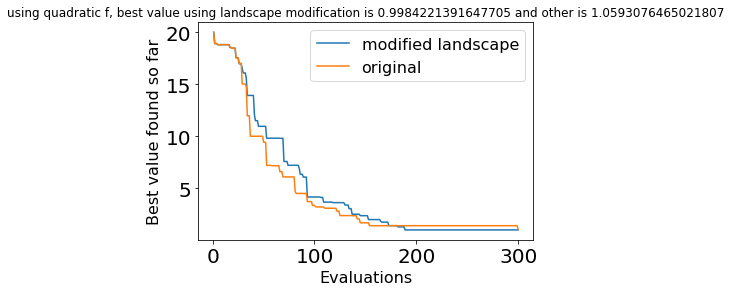

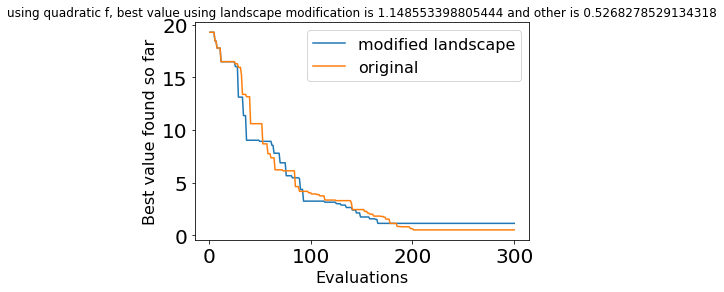

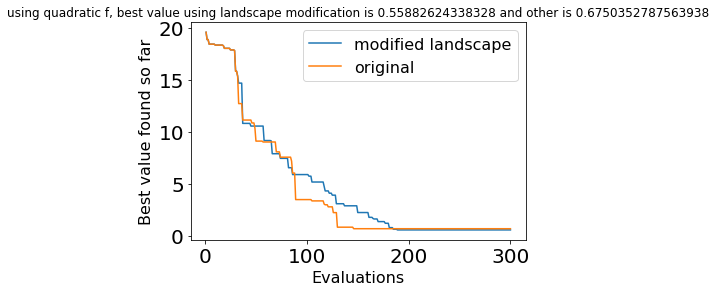

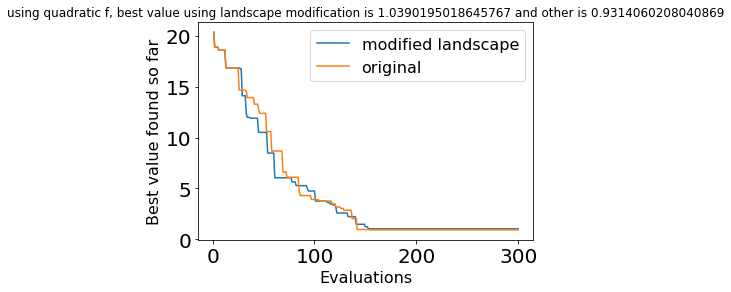

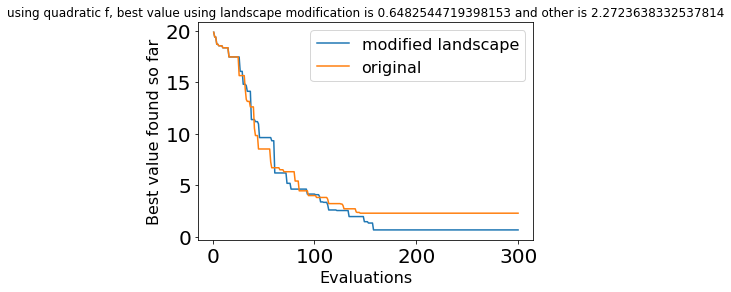

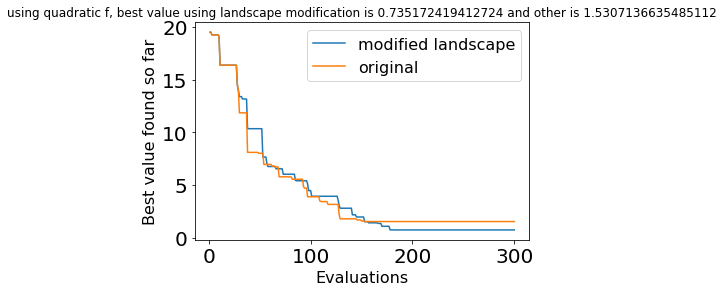

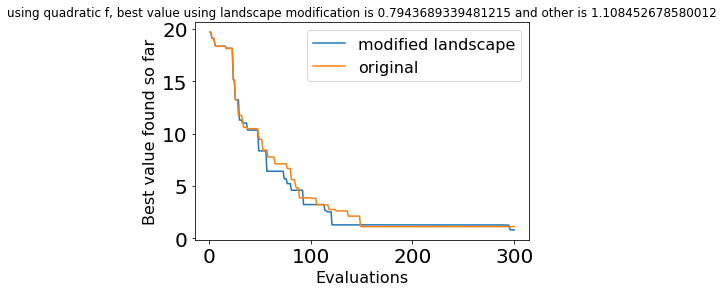

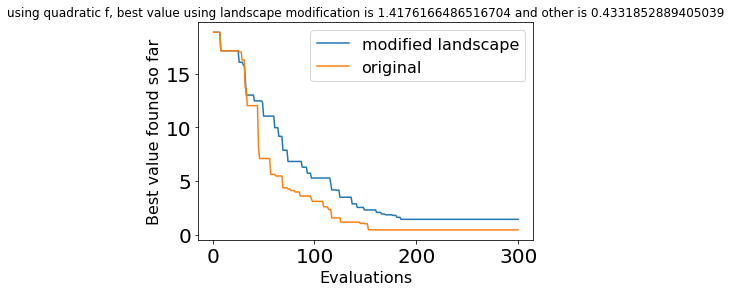

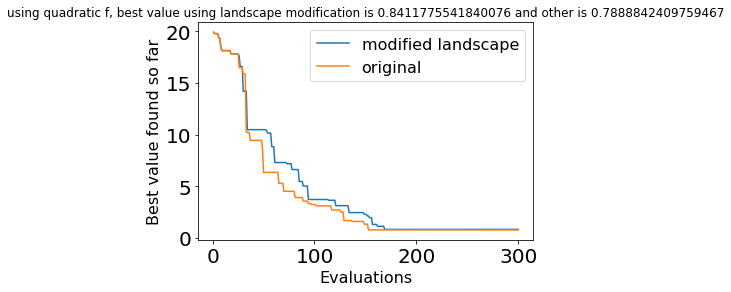

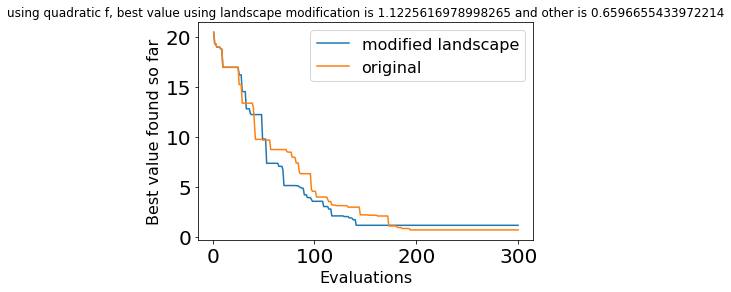

landscape modified was better 14 times and was worse 16 times
mean of landscape modified is 1.087368357548377
mean of non landscape modified is 0.9023862737900384
median of landscape modified is 0.9557278229289872
median of non landscape modified is 0.8279653284924415
standard_deviation of landscape modified is 0.4849462417648818
standard_deviation of non landscape modified is 0.40112289790851774
best result of landscape modified is 0.37093160884328613
best of non landscape modified is 0.31106889898986667
worst result of landscape modified is 2.4384001633707837
worst of non landscape modified is 2.2723638332537814


([1.6858765836511975,
  1.7662598572625225,
  0.6936963221404366,
  0.9130335066932038,
  2.197660402664909,
  0.7316817933243738,
  0.7250998054343651,
  0.7670460671285828,
  0.7998312871421764,
  1.595732071697459,
  1.2618279092028932,
  0.7333855323281822,
  1.3202758910176695,
  1.6503150178278259,
  1.2744367467142337,
  1.0376835888655447,
  2.4384001633707837,
  0.7466246536407337,
  0.37093160884328613,
  0.6072789082466881,
  0.9984221391647705,
  1.148553398805444,
  0.55882624338328,
  1.0390195018645767,
  0.6482544719398153,
  0.735172419412724,
  0.7943689339481215,
  1.4176166486516704,
  0.8411775541840076,
  1.1225616978998265],
 [0.8984119837228559,
  0.31106889898986667,
  1.1091570051625976,
  1.6779803121709205,
  0.45289094461767165,
  0.7782491798270113,
  0.850690410154137,
  0.8603470266098054,
  0.753865896667723,
  0.7233308512090564,
  1.059716904420363,
  0.7750470970444288,
  0.5380093883457069,
  0.9022355802790156,
  0.5227627751378034,
  0.59870960001

In [54]:
checker(30,path,l2)